In [11]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imgaug

import MobileMaskRCNN_build as build

from mmrcnn import utils
from mmrcnn import visualize
from mmrcnn.visualize import display_images
import mmrcnn.model as modellib
from mmrcnn.model import log
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [12]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



ROOT_DIR = build.ROOT_DIR
MODEL_DIR = build.MODEL_DIR
BURR_DIR = os.path.join(ROOT_DIR, "datasets\\burr")
ROOT_DIR, MODEL_DIR
config = build.mobileconfig()
config.USE_MULTIPROCESSING = True
config.STEPS_PER_EPOCH = 347
config.IMAGES_PER_GPU = 1
config.display()


Configurations:
BACKBONE                       mobilenetv1
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  5e-05
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               10
MEAN_PIXEL                     [123.7 116.8 103.

In [13]:
DEVICE = "/gpu:0"
TEST_MODE = "training"

In [14]:
dataset_train = build.MobileDataset()
dataset_train.load_burr(BURR_DIR, "train")
dataset_train.prepare()
print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))

Images: 347
Classes: ['BG', 'burr']


In [15]:
dataset_val = build.MobileDataset()
dataset_val.load_burr(BURR_DIR, "val")
dataset_val.prepare()
print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

Images: 117
Classes: ['BG', 'burr']


In [16]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode = "training", model_dir = MODEL_DIR, config = config)

In [ ]:
# weights_path = model.find_last()
# print("loading weights", weights_path)
# model.load_weights(weights_path, by_name = True)

weights_path = "C:\\Users\\ものづくり改革室\\MobileMaskRCNN\\packages\\Mobile_Mask_RCNN\\mobile_mask_rcnn_coco.h5"
model.load_weights(weights_path, by_name=True, exclude=[
        "mrcnn_class_logits", "mrcnn_bbox_fc",
        "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)
print("training network heads")
#augmentation = imgaug.augmenters.Fliplr(0.5)
model.train(dataset_train,
           dataset_val,
           learning_rate = config.LEARNING_RATE,
           epochs = 10,
           layers = "heads")

In [17]:
#config for inference
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 117
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.15

config_inf = InferenceConfig()
config_inf.display()


Configurations:
BACKBONE                       mobilenetv1
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.15
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  5e-05
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               10
MEAN_PIXEL                     [123.7 116.8 103.9

In [18]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config_inf)

In [19]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# Load COCO weights
#weights_path = kangaroo_mask_rcnn.COCO_WEIGHTS_PATH

# Or, load the last model you trained
weights_path = model.find_last()

# Or, specify one you want to use
#weights_path = "C:\\Users\\ものづくり改革室\\MobileMaskRCNN\\logs\\1024_mobile_config20200706T1701\\mask_rcnn_1024_mobile_config_0030.h5"

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path[1], by_name=True)

Loading weights  ('C:\\Users\\ものづくり改革室\\MobileMaskRCNN\\logs\\1024_mobile_config20200707T1520', 'C:\\Users\\ものづくり改革室\\MobileMaskRCNN\\logs\\1024_mobile_config20200707T1520\\mask_rcnn_1024_mobile_config_0010.h5')


B-0149(NG).jpg
Processing 1 images
image                    shape: (2048, 2448, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:   -1.00000  max:    0.99216  float32
image_metas              shape: (1, 14)               min:    0.00000  max: 2448.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
original_image_shape:  (2048, 2448, 3)
image_shape:  (1024, 1024, 3)
window before norm:  [  83    0  940 1024]
window after norm:  [0.08113392 0.         0.9178886  1.        ]
scale:  [0.8367547 1.        0.8367547 1.       ]
[0.9792378]
B-0150(NG).jpg
Processing 1 images
image                    shape: (2048, 2448, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:   -1.00000  max:    0.99216  float32
image_metas              shape: (1, 14)               min:    0.00000  max: 2448.00000  float64
anchors               

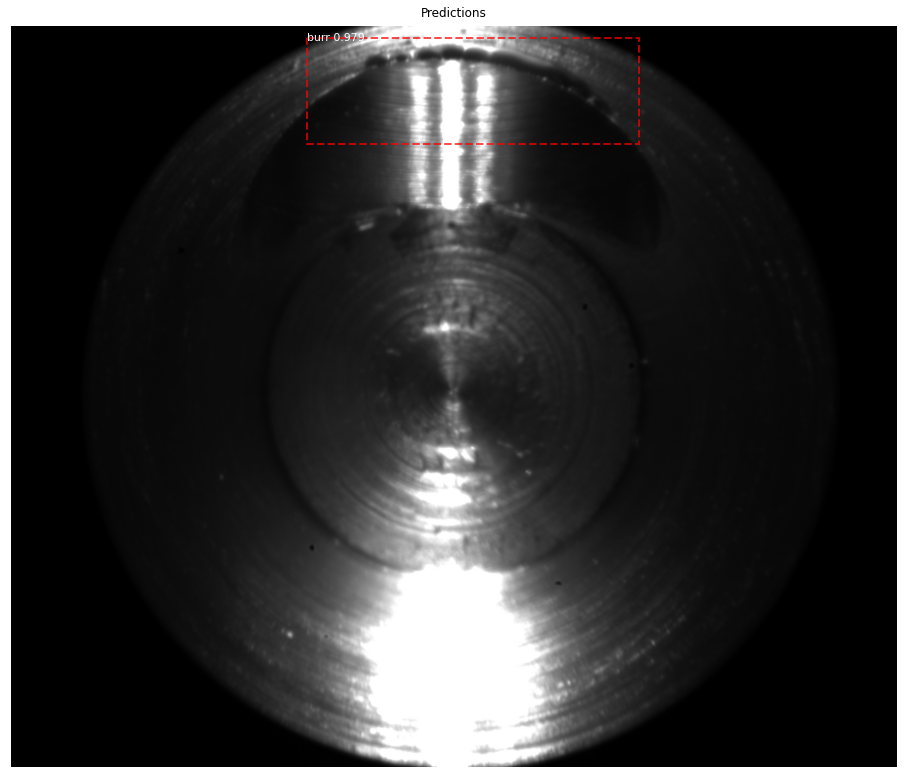

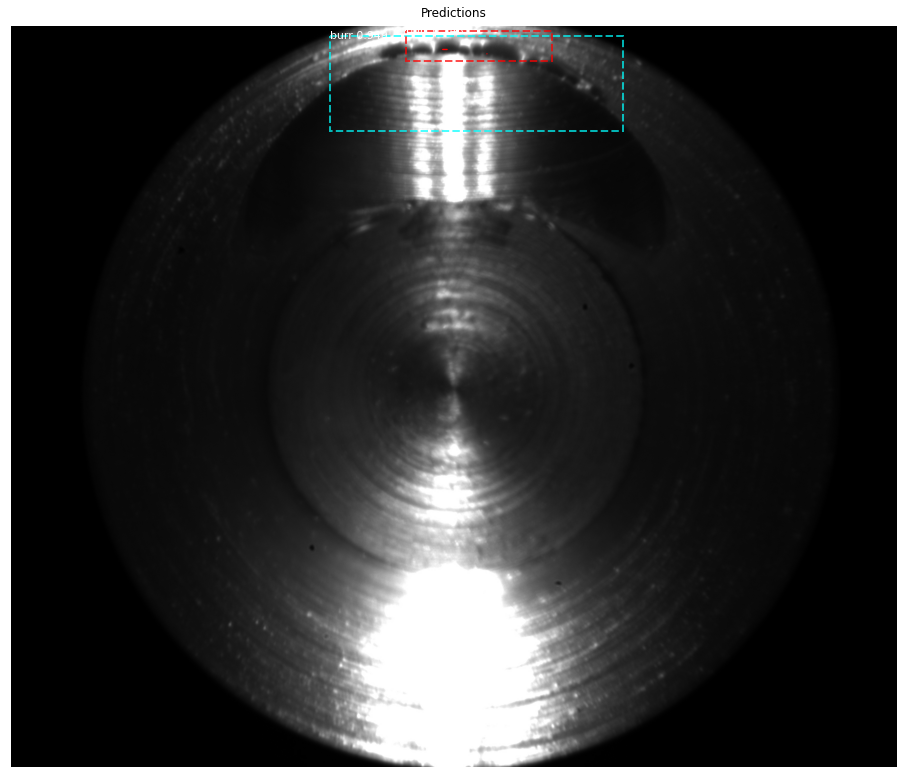

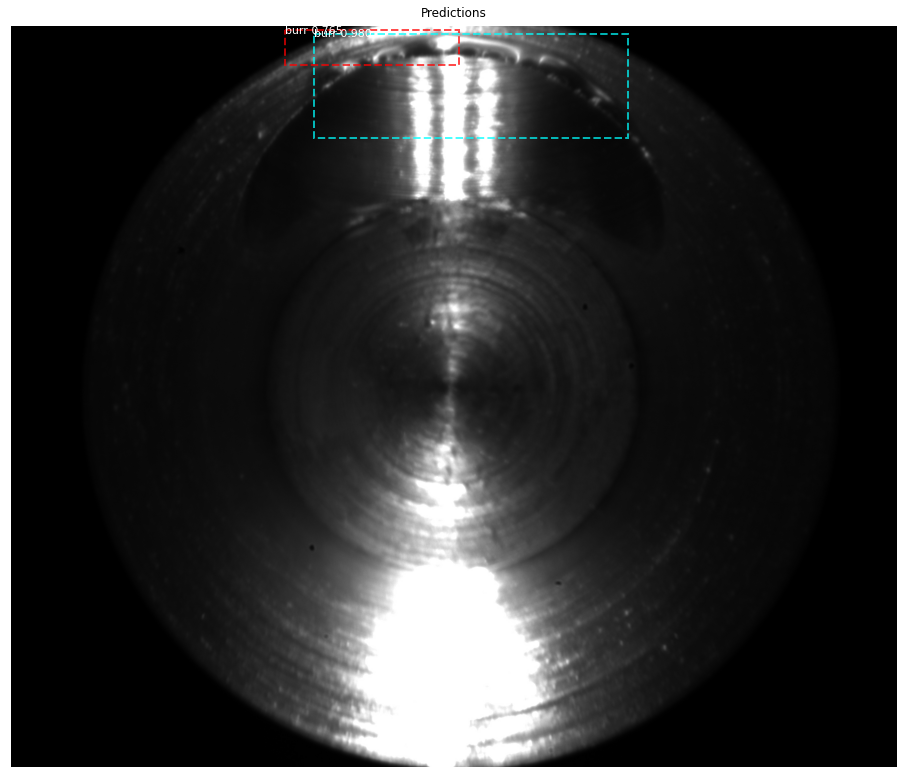

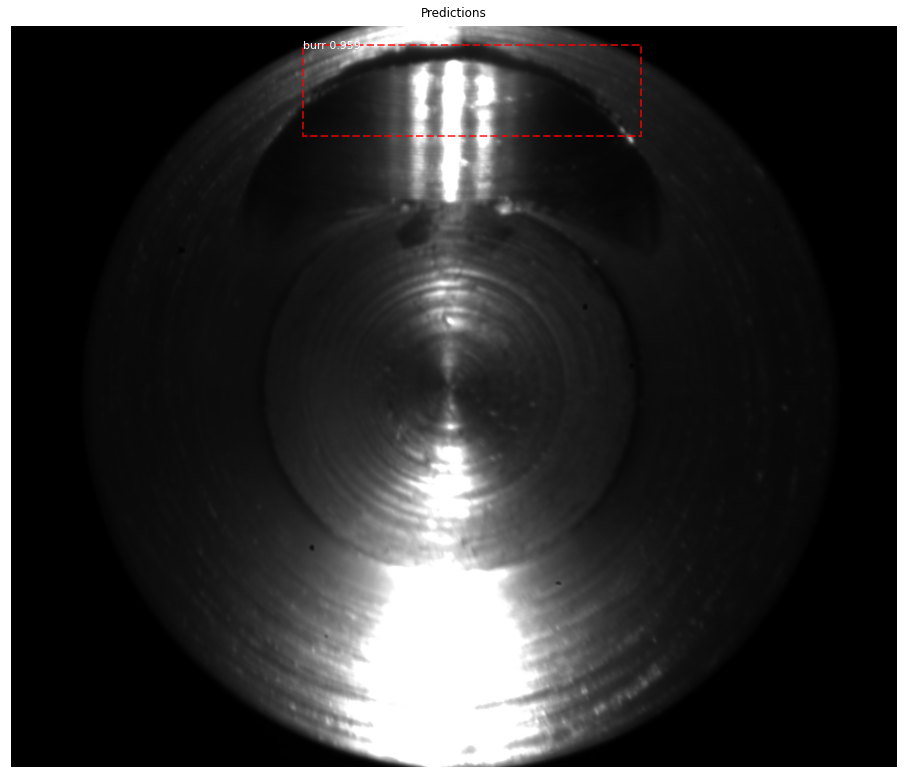

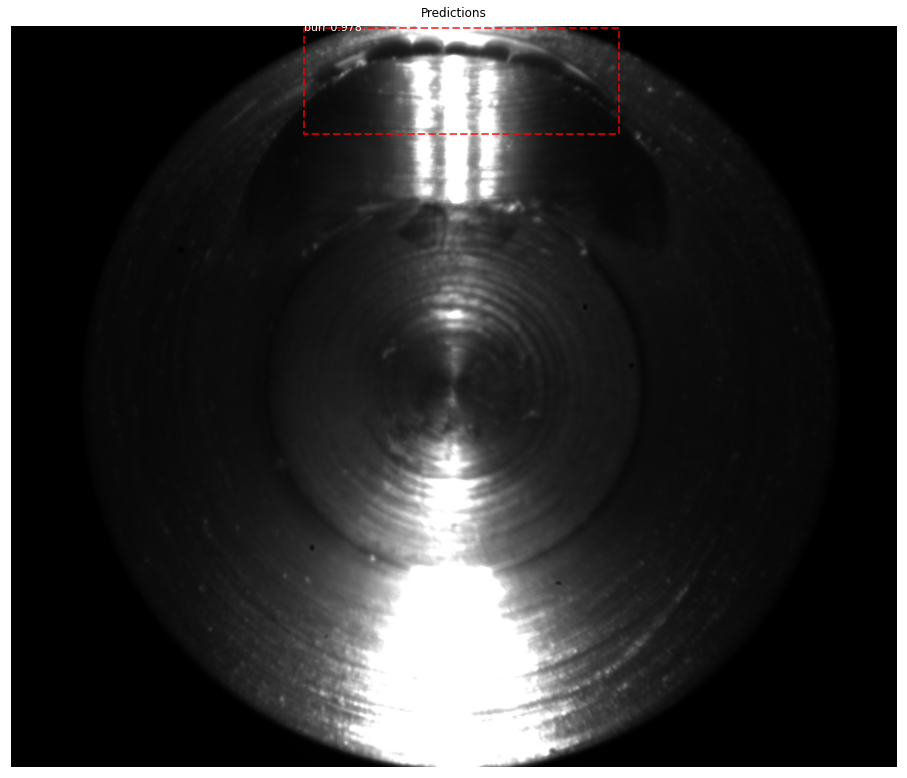

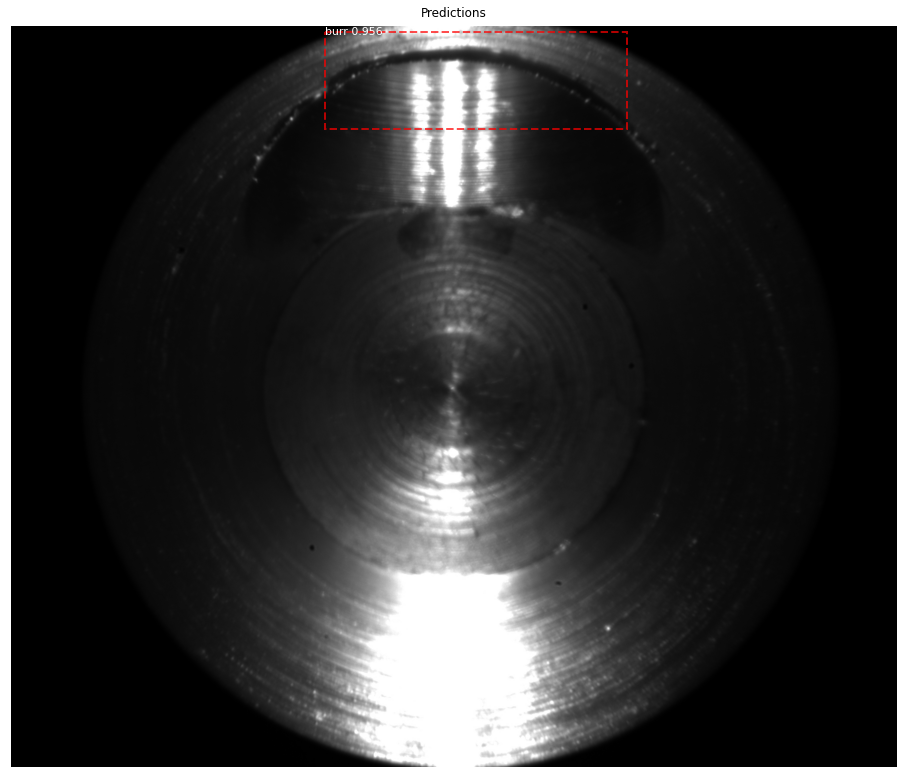

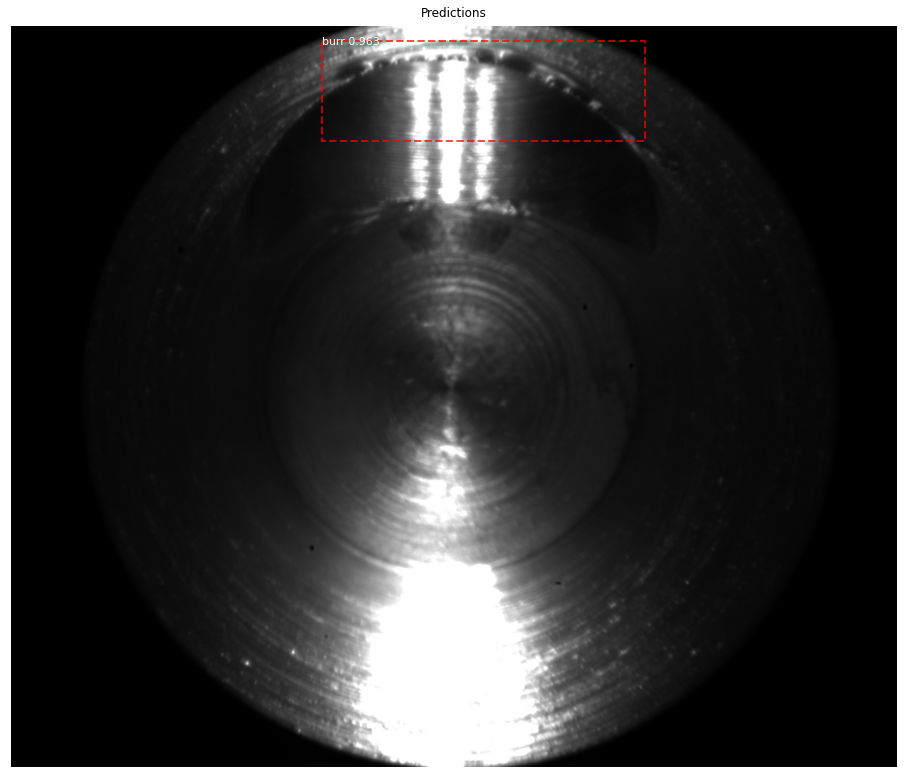

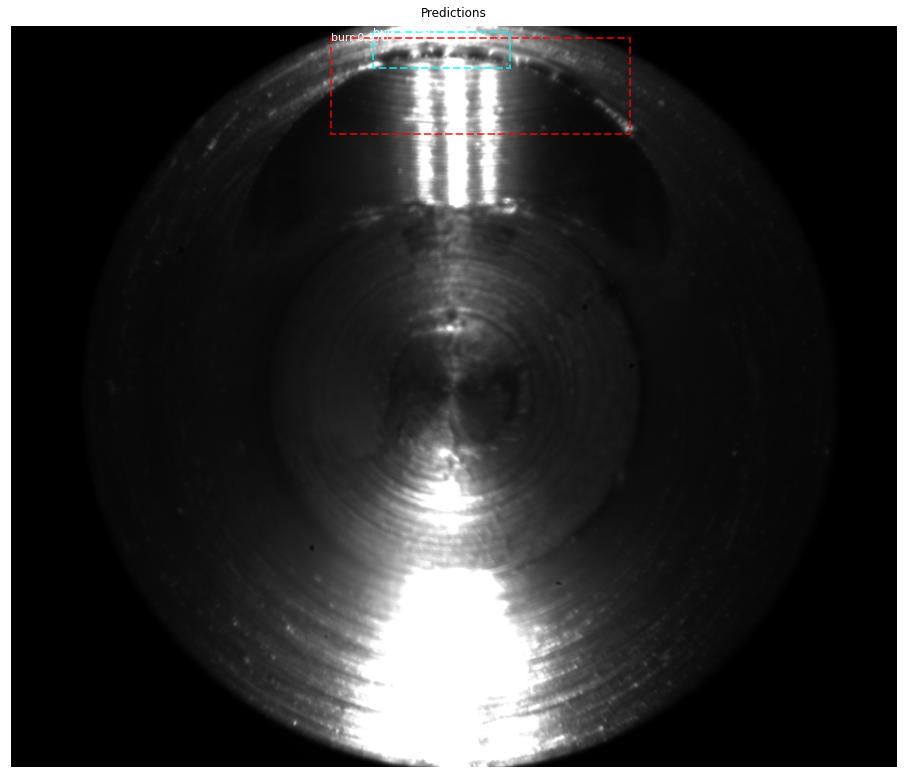

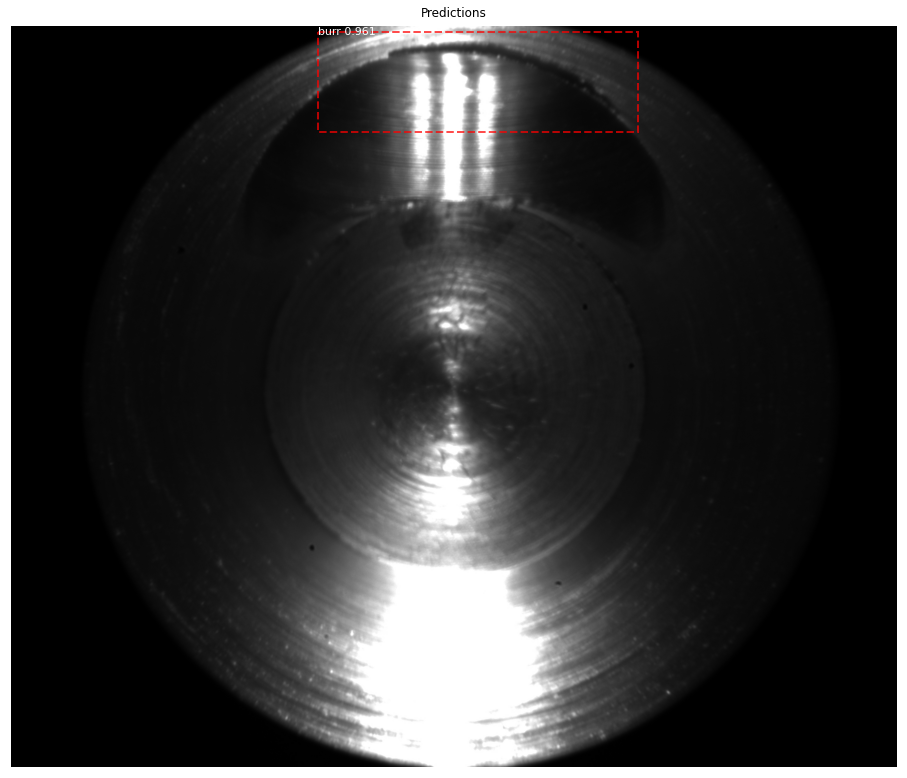

In [20]:
#without a ground truth
import imageio
import skimage
# Load a random image from the images folder
IMAGE_DIR = os.path.join(BURR_DIR, "val")
file_names = next(os.walk(IMAGE_DIR))[2]
for f in file_names[0:9]:
    print(f)
    image = imageio.imread(os.path.join(IMAGE_DIR, f))
    if image.ndim != 3:
        image = skimage.color.gray2rgb(image)
    # If has an alpha channel, remove it for consistency
    if image.shape[-1] == 4:
        image = image[..., :3]
    
# randim = random.choice(file_names)
# print(randim)
# image = imageio.imread(os.path.join(IMAGE_DIR, randim))
# if image.ndim != 3:
#     image = skimage.color.gray2rgb(image)
#     # If has an alpha channel, remove it for consistency
# if image.shape[-1] == 4:
#     image = image[..., :3]

    # Run detection
    results = model.detect([image], verbose=1)

    # Visualize results
    ax = get_ax(1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                    dataset_val.class_names, r['scores'], ax=ax,
                                    title="Predictions")
    print(r['scores'])

image ID: defects.B-0149(NG).jpg (0) C:\Users\ものづくり改革室\MobileMaskRCNN\datasets\burr\val\B-0149(NG).jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:   -1.00000  max:    0.99216  float32
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
original_image_shape:  (1024, 1024, 3)
image_shape:  (1024, 1024, 3)
window before norm:  [   0    0 1024 1024]
window after norm:  [0. 0. 1. 1.]
scale:  [1. 1. 1. 1.]
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   92.00000  max:  708.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
image ID: defects.B-0150(NG).jpg (1) C:\Users\もの

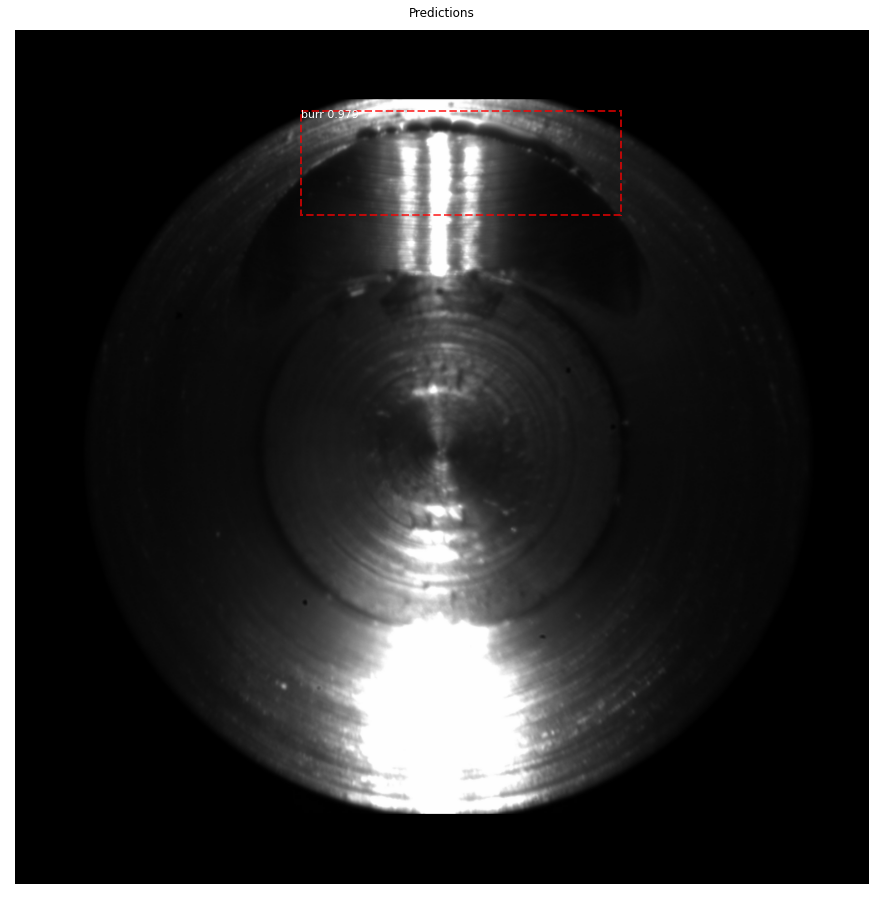

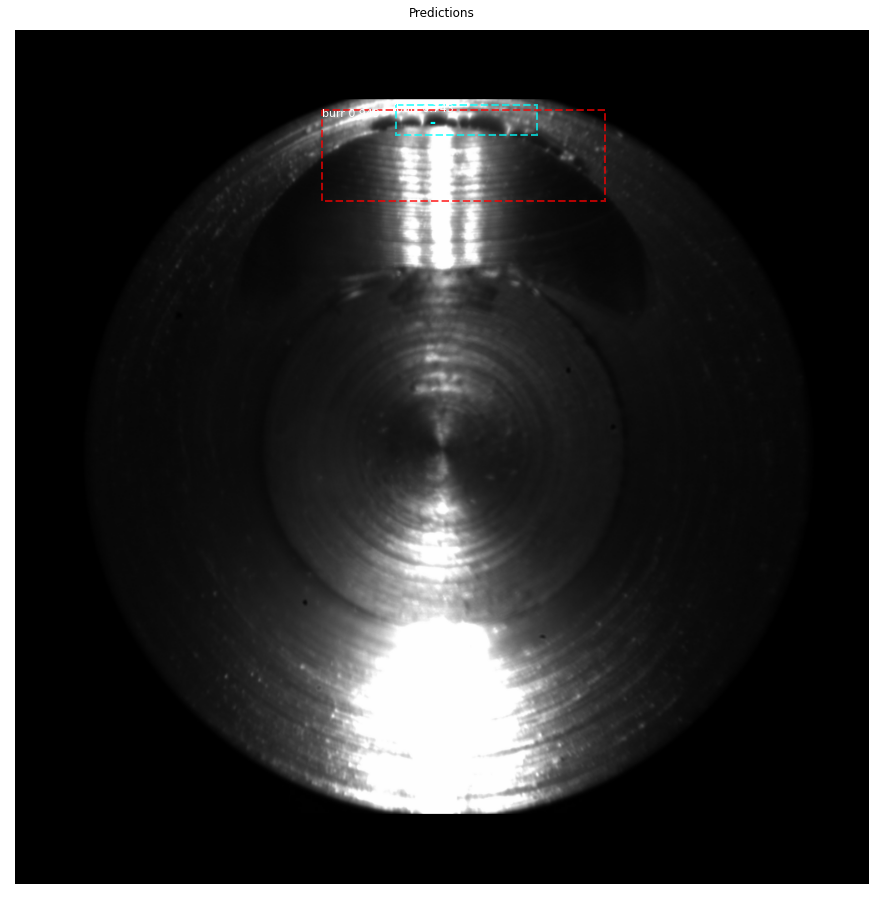

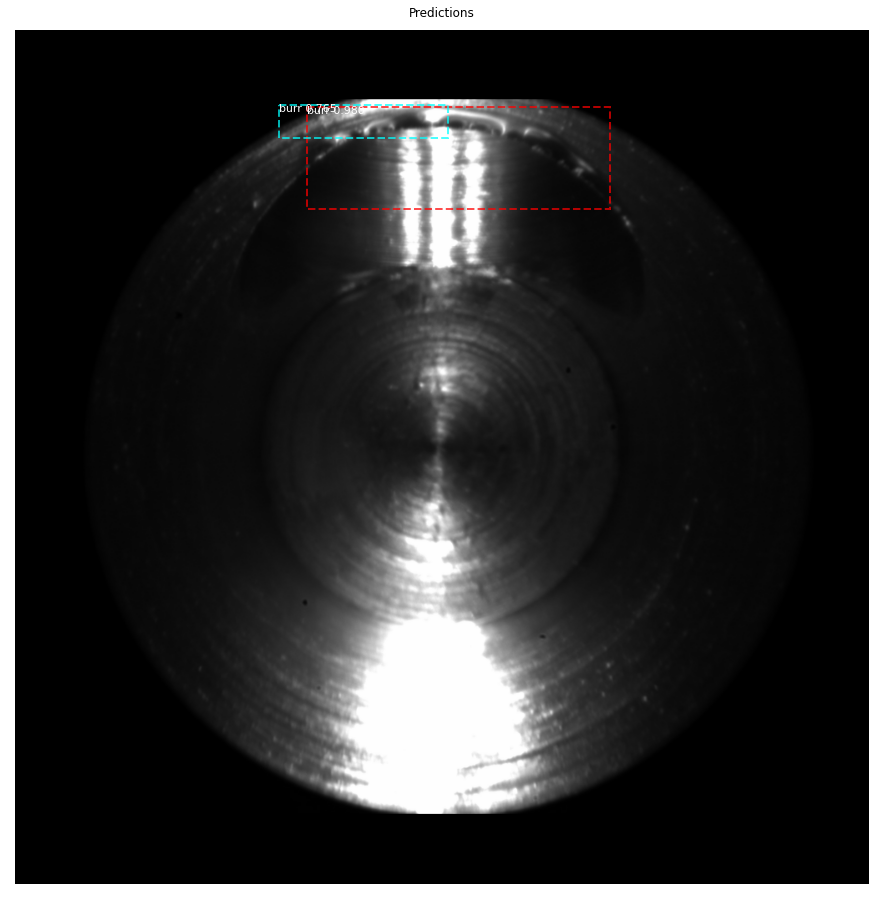

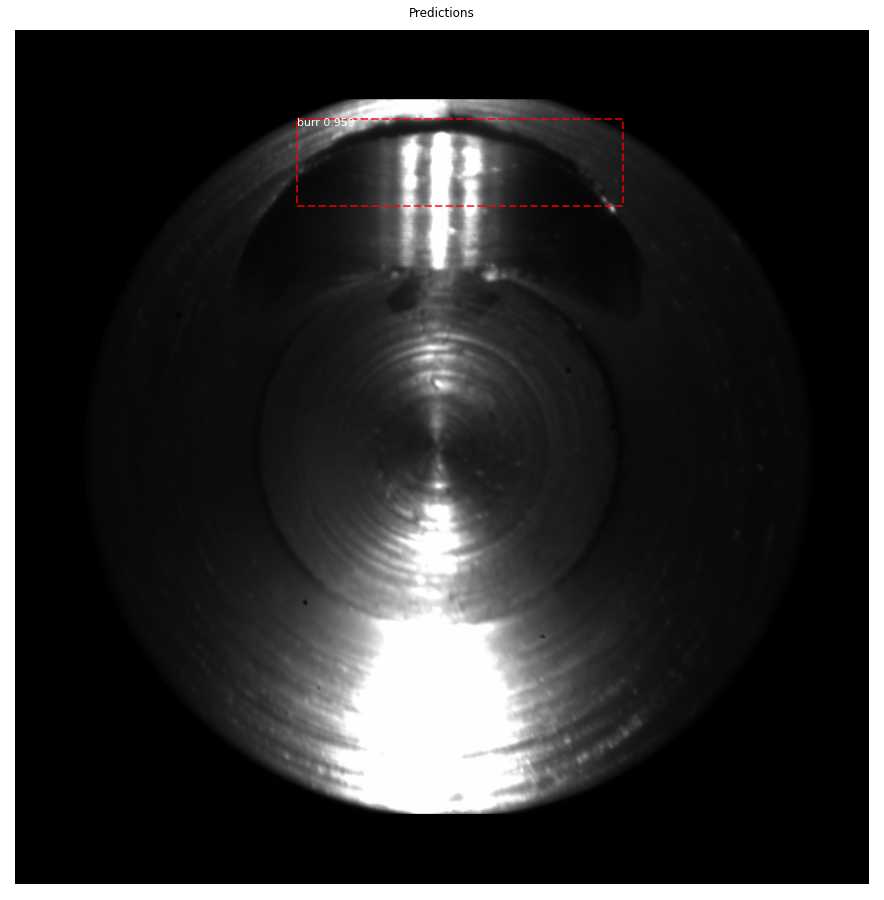

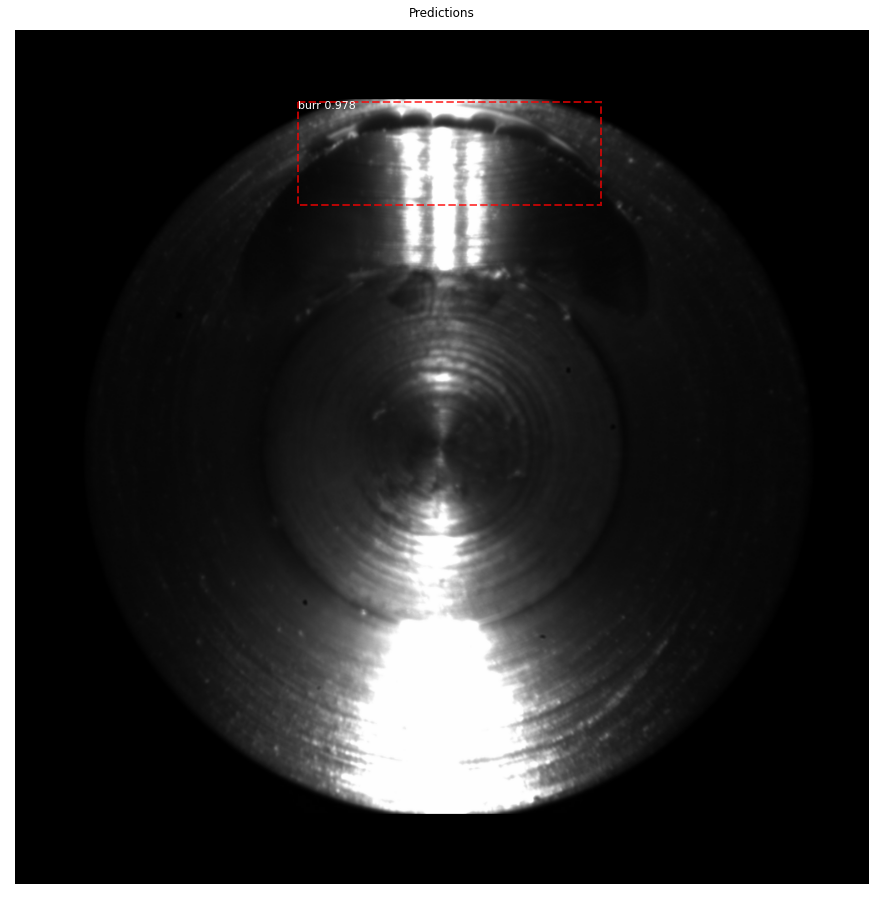

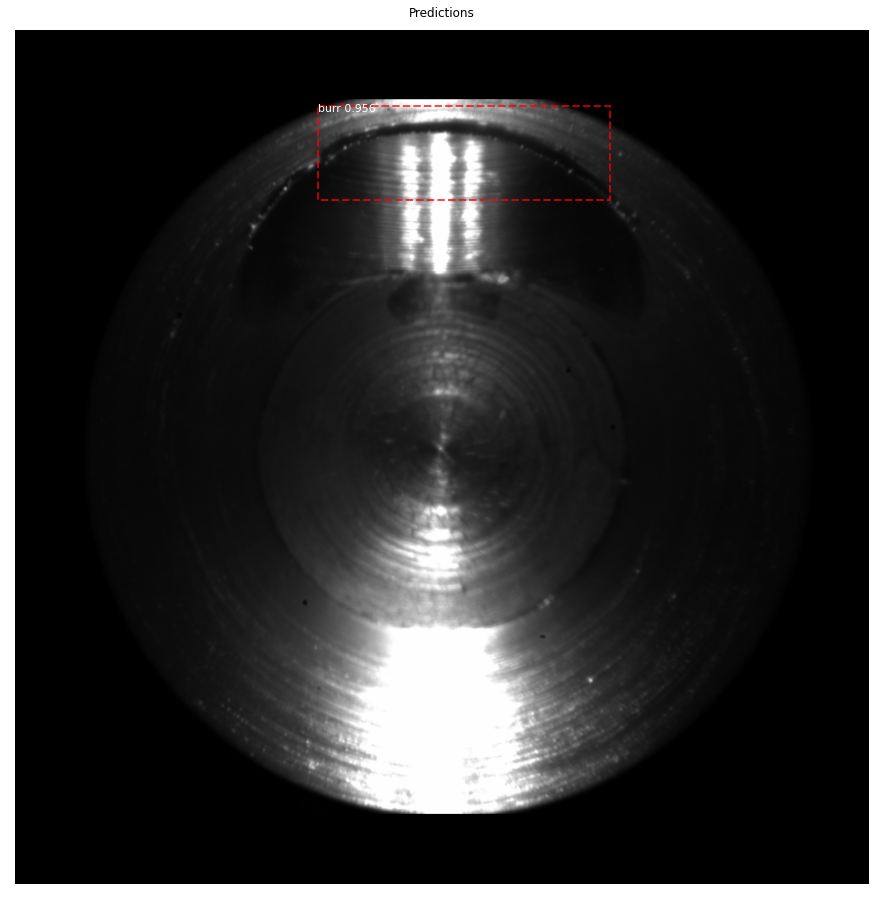

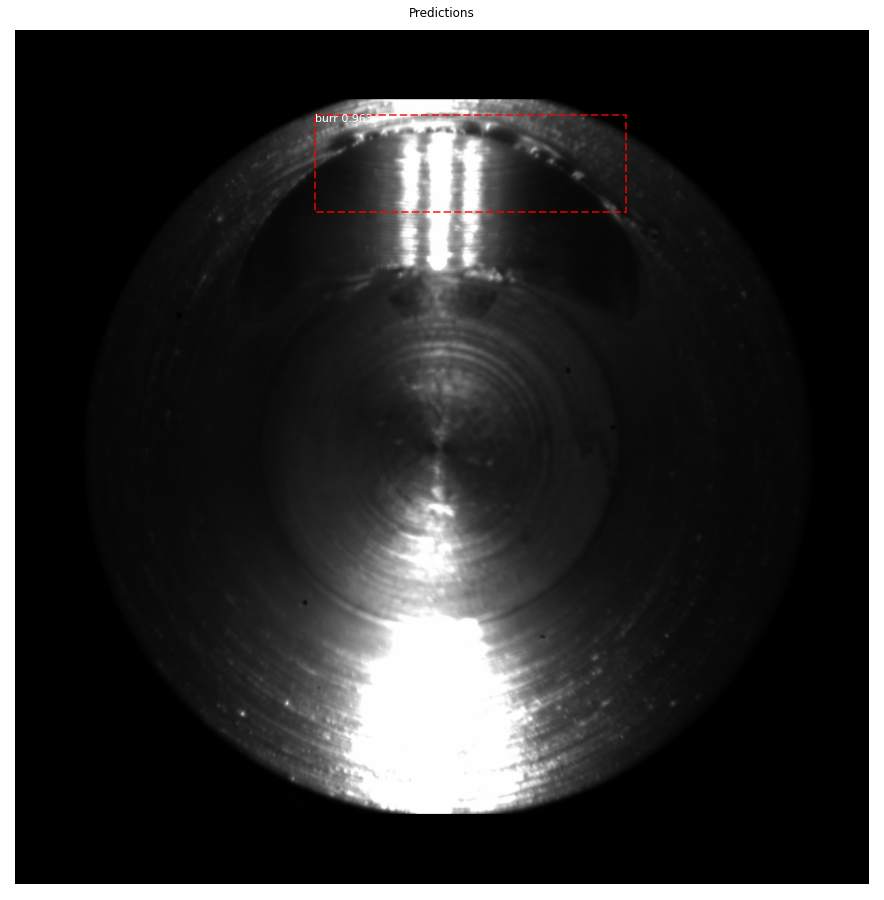

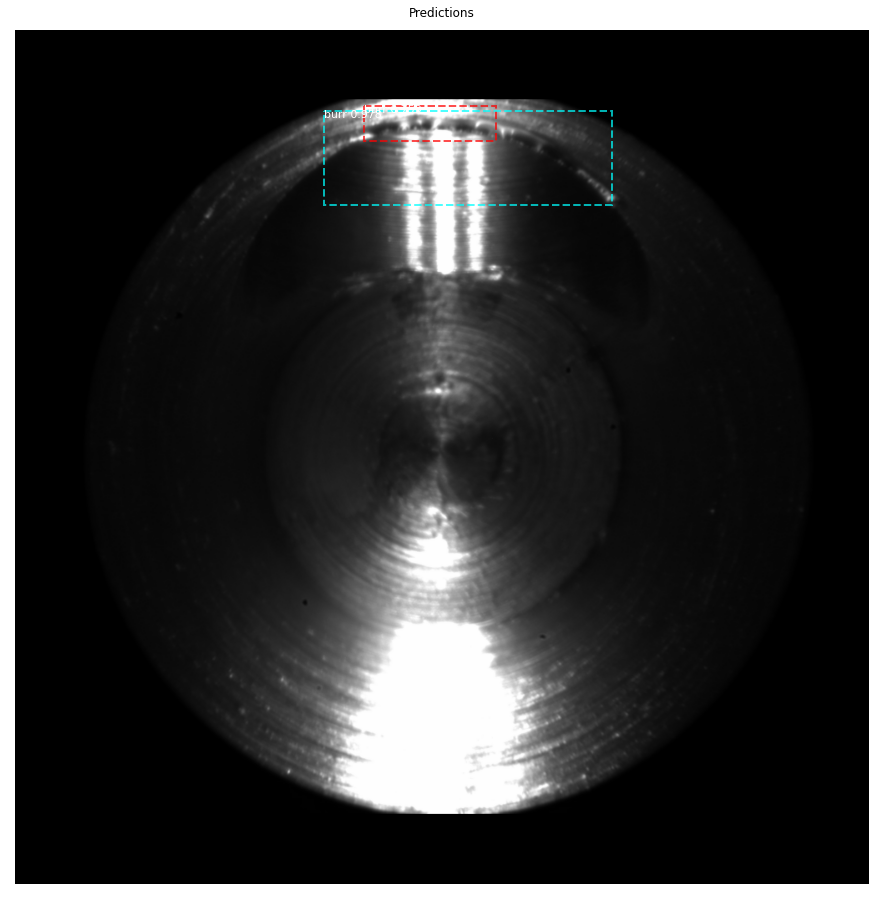

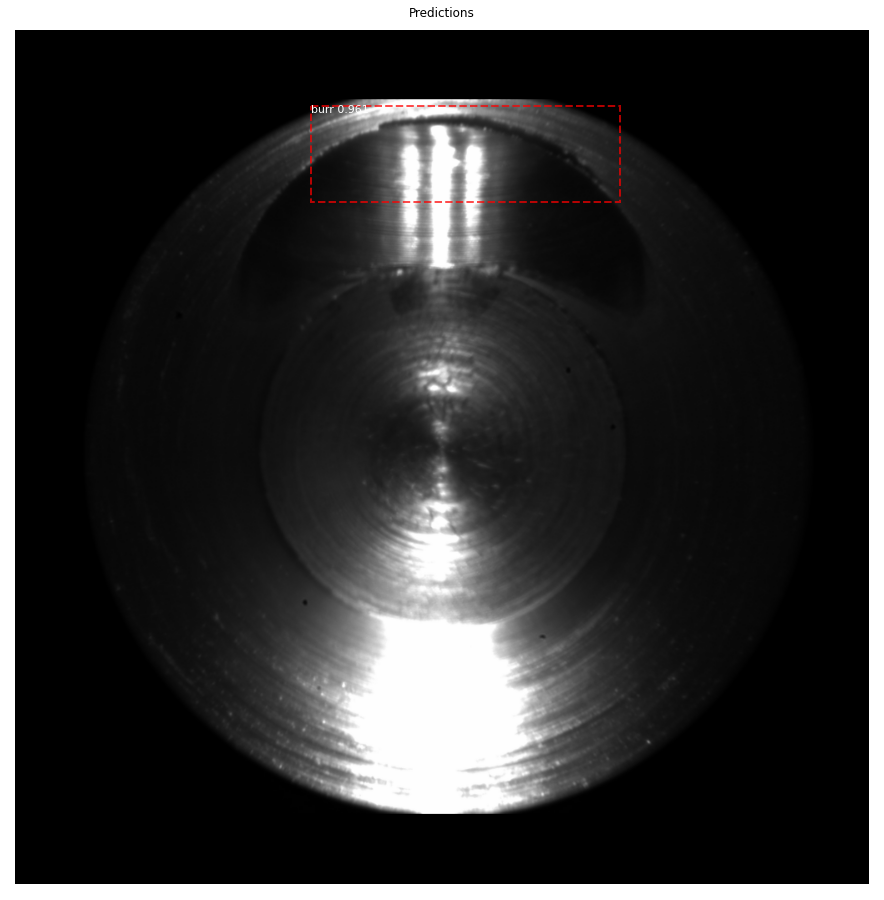

In [21]:
#for images with ground truth
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import imageio
import skimage
for image_id in dataset_val.image_ids[0:9]:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
    info = dataset_val.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))
    # Run object detection
    results = model.detect([image], verbose=1)

    # Display results
    ax = get_ax(1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=ax,
                                title="Predictions", show_bbox = True, show_mask = True)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

In [ ]:
visualize.display_top_masks(image, r['masks'], r['class_ids'], dataset_val.class_names)
visualize.display_weight_stats(model)

In [ ]:
import numpy
from PIL import Image
results = model.detect([image], verbose = 0)
r = results[0]
numpy.set_printoptions(threshold=100)
Image.fromarray(r['masks'])